In [50]:
import qutip as qt
from qutip import *

##Qiskit libraries
import qiskit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import entropy

from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

#scipy
import scipy
import itertools
from scipy.special import psi, polygamma
import math

In [128]:
def str_gen(n,s):
    k = int((s + n)/2)

    ##ow we have to generate all strings of length n with val 0's as a list

    ##we can use the itertools library to generate all combinations of n choose val
    if k > n or k < 0:
        raise ValueError("k must be between 0 and n inclusive")

    positions = range(n)
    zero_positions_combinations = itertools.combinations(positions, k)

    bitstrings = []
    for zero_positions in zero_positions_combinations:
        bits = ['1'] * n
        for pos in zero_positions:
            bits[pos] = '0'
        bitstrings.append(''.join(bits))

    return bitstrings

def num_gen(n,s):
    k = int((s + n)/2)

    ##ow we have to generate all strings of length n with val 0's as a list

    ##we can use the itertools library to generate all combinations of n choose val
    if k > n or k < 0:
        raise ValueError("k must be between 0 and n inclusive")

    return math.comb(n,k)

#TEST THIS FUNCTION

print(str_gen(4,0))
print('00'+'10')

def str_sum(l1,l2):

    #Returns  a list where every element is sum of strings in l1 and l2, all combinations
    #l1 = ['00','01']
    #l2 = ['00','10']
    #returns ['0000','0010','0100','0110']

    l3 = []
    for i in range(len(l1)):
        for j in range(len(l2)):
            l3.append(l1[i] + l2[j])
    return l3

def sample_simplex(J, alpha=None, num_samples=1):
    """
    Sample probability vectors over a J-dimensional simplex using Dirichlet distribution.

    Args:
        J (int): Number of probability components.
        alpha (list or float): Dirichlet parameters. If None, defaults to uniform (all ones).
        num_samples (int): Number of samples to draw.

    Returns:
        np.ndarray: Array of shape (num_samples, J) with rows summing to 1.
    """
    if alpha is None:
        alpha = [1.0] * J  # Uniform Dirichlet distribution
    elif isinstance(alpha, (int, float)):
        alpha = [alpha] * J  # Symmetric Dirichlet with scalar alpha

    samples = np.random.dirichlet(alpha, size=num_samples)
    return samples

# Example usage
"""J = 5
samples = sample_simplex(J, alpha=1.0, num_samples=1)
print("Sampled probability vectors (each sums to 1):")
print(samples)"""

def vn_reduced(phi,Na,N):

    ##Trace out the last N-Na qubits and take von Neumann entropy
    ##phi is a statevector
    ##Na is the number of qubits we want to keep

    ##N is the total number of qubits

    keep = list(range(N - Na, N))         # e.g., if N=10, Na=4 → keep [6,7,8,9]
    trace_out = [i for i in range(N) if i not in keep]  # trace out last N - NA qubits

    #trace_out = list(range(Na, N))
    reduced = partial_trace(phi, trace_out)
    return entropy(reduced, base=np.e)

def vn_an(da,db):
    return psi(da*db + 1) - psi(db + 1) - (da - 1)/(2*db)


def var(da,db):
    return ((da + db)/(da*db + 1))*polygamma(1,db+1) - polygamma(1,da*db + 1) - (da - 1)*(da + 2*db - 1)/(4*(db**2)*(da*db + 1))

def HaarState(N):
    coeffs = []
    for i in range(2**N):
        z = np.random.randn() + 1j * np.random.randn()
        coeffs.append(z)
    coeffs = np.array(coeffs)
    hst = Statevector(coeffs)/np.linalg.norm(coeffs)
    return hst


    

['0011', '0101', '0110', '1001', '1010', '1100']
0010


In [123]:
##Let us test the von neumann entropy function

N = 4
Na = 2
test_basis = ['1100','1101','1110','1111']
state = Statevector(np.zeros(2**N,dtype=complex))
#print('Statevector:', state)
for basis in test_basis:
    z = np.random.randn() + 1j * np.random.randn()
    state += z*Statevector.from_label(basis)
state = state/np.linalg.norm(state)
print('Statevector:', state)

print('Von Neumann entropy:',vn_reduced(state,Na,N))

Statevector: Statevector([ 0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
             -0.50202223-0.18960395j, -0.49848384+0.41020983j,
             -0.52734834+0.04159771j, -0.12246745+0.02099656j],
            dims=(2, 2, 2, 2))
Von Neumann entropy: 0.0


In [172]:
##Firstly, we take E = \mu_0 B \sum _i \sigma_i

#Test everything on small system sizes first

N = 10
Na = 4
mu = 1
B = 1

dim = 2**N

sigma_sum = -2
samples = 10**5

#Now, we have the following sub problem: given N numbers taking values of 1 or -1, how many of these configurations sum up to a given value?
#Create two lists

na_list = list(range(-Na,Na+1,2))
nb_list = list(range(-N+Na,N-Na+1,2))

dja_list = []
djb_list = []
index = nb_list.index(sigma_sum - na_list[0])
i = 0
while i <= len(na_list)-1 and index >= 0:
    dja_list.append(num_gen(Na,na_list[i]))
    djb_list.append(num_gen(N-Na,nb_list[index]))
    i += 1
    index -= 1
print('dja_list',dja_list)
print('djb_list',djb_list)




sample_phi_list = []
J = 0 ##To be updated in the loop

for i in range(samples):

    phi_list = []

    if abs(sigma_sum)%2 == N%2 and abs(sigma_sum) <= N:

        index = nb_list.index(sigma_sum - na_list[0])
        i = 0
        while i <= len(na_list)-1 and index >= 0:
            phi = str_sum(str_gen(Na,na_list[i]),str_gen(N-Na,nb_list[index]))
            #print('phi',phi)
            phi_list.append(phi)
            i += 1
            index -= 1
    else:
        print('No valid configurations')
        sys.exit()

    """print('phi_list',phi_list)

    print('J',J)
    print(int('0010',2))"""
    J = len(phi_list)  

    #print("Basis states:",phi_list)

    ##We will check the page mean for each sector, to see if the sampling works

    """set_sample = 5000
    for i in range(J):
        print("J = ",i+1)
        dja = dja_list[i]
        djb = djb_list[i]
        dj = dja*djb
        de = math.comb(N,Na)
        print('dja:',dja,"djb:",djb)
        basis_phi = phi_list[i]
        ent_list = []
        for k in range(set_sample):
            #Form pure state
            #print("basis_phi",basis_phi)
            state = Statevector(np.zeros(2**N, dtype=complex))
            for basis in basis_phi:
                z = np.random.randn() + 1j * np.random.randn()
                state += z*Statevector.from_label(basis)
            state = state/np.linalg.norm(state)
            ent_list.append(vn_reduced(state,Na,N))
        #Sample entropy mean
        ent_mean = np.mean(ent_list)
        ent_var = np.var(ent_list)
        print('Sample mean:',ent_mean)
        print('Page mean:',vn_an(dja,djb)) #+ psi(de+1) - psi(dj+1))
        print('Sample variance:',ent_var)
        print('Page variance:',var(dja,djb))
        print()"""


    phi_state_list = []
    for i in range(len(phi_list)):
        state_in = Statevector(np.zeros(2**N, dtype=complex))
        for j in range(len(phi_list[i])):
            z = np.random.randn() + 1j * np.random.randn()
            state_in += z*Statevector.from_label(phi_list[i][j])
        state_fin = state_in/np.linalg.norm(state_in)
        phi_state_list.append(state_fin)

    sample_phi_list.append(phi_state_list)

    """print('phi_state_list',phi_state_list)
    for i in range(len(phi_state_list)):
        print('state validity',phi_state_list[i].is_valid())"""

print('J =',J)
prob_samples = sample_simplex(J, alpha=1.0, num_samples=samples)
##Now, we have to sample over a simplex, as in J values of probability, summing to 1
##We can use the Dirichlet distribution to sample over a simplex

ent_entropy_list = []
for i in range(samples):
    ent_entropy = 0
    #ent_entropy2 = 0
    #fin_state = Statevector(np.zeros(2**N, dtype=complex))
    #print('prob_samples',prob_samples[i])
    #print('Sum of probabilities:', np.abs(np.sum(prob_samples[i])-1))
    for j in range(len(sample_phi_list[i])):
        ent_entropy += prob_samples[i][j]*vn_reduced(sample_phi_list[i][j],Na,N) - prob_samples[i][j]*np.log(prob_samples[i][j])

        #Let us also form the state and directly compute the entropy
        #fin_state += np.sqrt(prob_samples[i][j])*sample_phi_list[i][j]
        #print(np.abs(np.linalg.norm(sample_phi_list[i][j]) - 1))
    #fin_state = fin_state/np.linalg.norm(fin_state)
    #ent_entropy2 = vn_reduced(fin_state,Na,N)
    #print('ent_diff:',np.abs(ent_entropy-ent_entropy2))
    ent_entropy_list.append(ent_entropy)

print('ent_entropy_list length',len(ent_entropy_list))

##Product of dja and djb
sum = 0
for i in range(len(dja_list)):
    sum += dja_list[i]*djb_list[i]

print("Sector dim:", sum)
            

    

dja_list [1, 4, 6, 4, 1]
djb_list [15, 20, 15, 6, 1]
J = 5
ent_entropy_list length 100000
Sector dim: 210


Sample mean: 2.0774318430249723
Sample variance: 0.10835803382762059
Trivial variance: 0.0001062213282703544
Theoretical mean: 2.483686939975974
Theoretical variance: 0.0011517800054345881


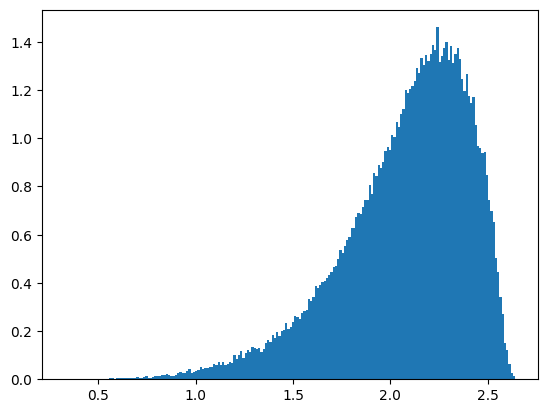

In [173]:
#np.savetxt(f'ent_entropy_list_N={N},Na={Na},sigma_sum={sigma_sum}_2.txt', ent_entropy_list)

#print('ent_entropy_list',ent_entropy_list[0:10])
#ent_entropy_list = np.loadtxt(f'ent_entropy_list_N={N},Na={Na},sigma_sum={sigma_sum}.txt')

print("Sample mean:", np.mean(ent_entropy_list))
print("Sample variance:", np.var(ent_entropy_list))

plt.hist(ent_entropy_list, bins=200,density = True)

dA = 2**(Na)
dB = 2**(N-Na)
de = 0
for i in range(len(dja_list)):
    de += dja_list[i]*djb_list[i]

mean = 0
for i in range(len(dja_list)):
    dj = dja_list[i]*djb_list[i]
    mean += (dj/de)*(vn_an(dja_list[i],djb_list[i]) + psi(de + 1) - psi(dj + 1))

sigma = 0
for i in range(len(dja_list)):
    dj = dja_list[i]*djb_list[i]
    sigma += (dj*(dj+1)/(de*(de+1)))*(var(dja_list[i],djb_list[i]) - polygamma(1,de+2) + polygamma(1,dj+2) +(vn_an(dja_list[i],djb_list[i]) +psi(de+2) - psi(dj+2))**2)

for i in range(len(dja_list)):
    dia = dja_list[i]
    dib = djb_list[i]
    di = dia*dib
    for j in range(len(djb_list)):
        dja = dja_list[j]
        djb = djb_list[j]
        dj = dja*djb
        if i != j:
            sigma += (di*dj/(de*(de+1)))*((vn_an(dia,dib) + psi(de + 2) - psi(di + 1))*(vn_an(dja,djb) + psi(de + 2) - psi(dj + 1)) - polygamma(1,de + 2))

print("Trivial variance:", var(dA,dB))

sigma = np.sqrt(sigma - mean**2)

print('Theoretical mean:',mean)
print('Theoretical variance:',sigma**2)

##Plot a gaussian with mean and sigma over the histogram
x = np.linspace(min(ent_entropy_list), max(ent_entropy_list), 1000)
y = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mean)/sigma)**2)
#plt.plot(x, y, color='red', label='Gaussian fit')


##Not so sure about values away from half-filling


In [140]:
###Let us try if the trivial centre graphs work...

trivial_mean = vn_an(dA,dB)

print('trivial_mean:',trivial_mean)


#Let us check for the Haar Random states

samples = 10**5

trivial_ent_list = []
for i in range(samples):
    state = HaarState(N)
    trivial_ent_list.append(vn_reduced(state,Na,N))







trivial_mean: 2.648097268572366


N: 10 Na: 4
Page mean: 2.648097268572366
sample mean: 2.648088642026913
Page variance: 0.0001062213282703544
Sample variance: 0.00010558439434179217


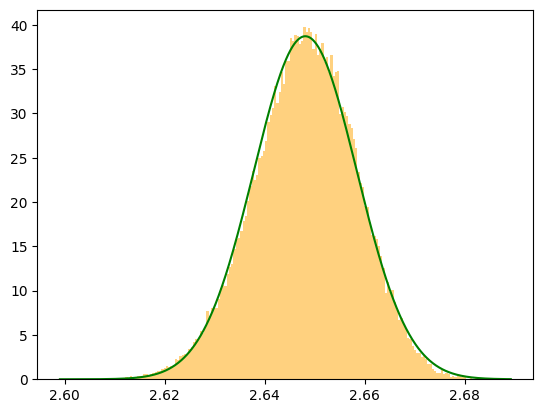

In [141]:
#Orange histogram
plt.hist(trivial_ent_list, bins=200,density = True, color='orange', alpha=0.5, label='Haar random states')
#Plot appropriate gaussian

print("N:",N,"Na:",Na)

dA = 2**Na
dB = 2**(N-Na)

mu = vn_an(dA,dB)
print("Page mean:",mu)
print("sample mean:", np.mean(trivial_ent_list))
sigma = np.sqrt(var(dA,dB))

print("Page variance:",sigma**2)
print("Sample variance:", np.var(trivial_ent_list))
x = np.linspace(min(trivial_ent_list), max(trivial_ent_list), 1000)
y = 1/(sigma*np.sqrt(2*np.pi)) *np.exp(-0.5 * ((x - mu)/sigma)**2) # 


plt.plot(x, y, color='green', label='Gaussian fit')